In [1]:
 # Ignore SQLITE warnings related to Decimal numbers in the Hawaii database
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Normal Analytics Dependencies
import matplotlib
import pandas as pd
import numpy as np
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import datetime
from sqlalchemy.orm import Session
import seaborn as sns
style.use('seaborn')

#ORM Dependencies
import sqlalchemy
from sqlalchemy import create_engine, MetaData
from sqlalchemy import create_engine, Column, Integer, String, Float, inspect, MetaData, func
from sqlalchemy.ext.automap import automap_base

#Creating Engine for Database
engine = create_engine("sqlite:///Hawaii.sqlite", echo=False)
inspector = inspect(engine)

In [3]:
#Reflecting Tables in Database
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['Measurement', 'Station']

In [4]:
#Using inspect engine to view column information
columns_m = inspector.get_columns('Measurement')
for column in columns_m:
    print(column["name"], column["type"])

M_ID INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER


In [5]:
#Using inspect engine to view column information
columns_s = inspector.get_columns('Station')
for column in columns_s:
    print(column["name"], column["type"])

S_ID VARCHAR
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
Measurement = Base.classes.Measurement
Station = Base.classes.Station

In [7]:
session = Session(engine)

In [8]:
session.query(func.count(Measurement.date)).all()

[(18103)]

In [9]:
#First date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [10]:
#Last date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [11]:
#Grabbing data from August 2016-2017
prcp_data = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > '2016-08-23').\
    order_by(Measurement.date).all()

In [12]:
prcp_df = pd.DataFrame(prcp_data, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True)
prcp_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


<IPython.core.display.Javascript object>


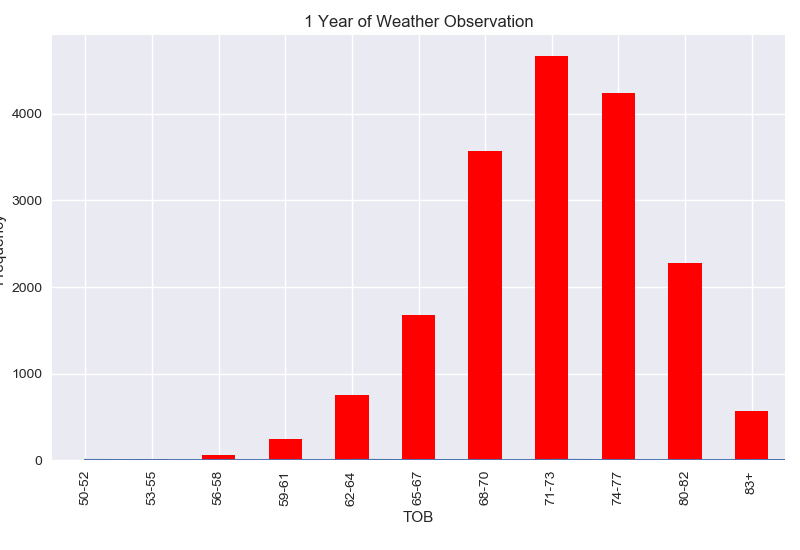

In [13]:
#x_axis = prcp_df.index[0::40]
labels = ['Aug 2016', 'Oct 2016',"'Dec 2017", 'Feb 2017', "April 2017", "June 2017", "July 2017"]
fig, ax = plt.subplots()

x = range(len(prcp_df))
ax.plot(prcp_df)
#plt.xticks(x_axis)
plt.xticks(prcp_df.index[0::300],labels,rotation='vertical')
ax.set_title('1 Year Hawaii Percipitation')
plt.ylabel("Precipitation")
fig.tight_layout()
plt.savefig("images/PRCP.png")
fig.show()

In [14]:
#Total number of stations
session.query(func.count(Station.S_ID)).all()

[(9)]

In [15]:
station_data = session.query(Measurement.station,func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.tobs).desc()).all()

In [16]:
s_df = pd.DataFrame(station_data, columns=['station','tob_count'])
s_df.head(50)

,station,tob_count
0,USC00519397,2685
1,USC00519281,2772
2,USC00513117,2696
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


#### USC00519397 is the most active station

In [17]:
tobs_data = session.query(Measurement.station,Measurement.tobs).\
    filter(Measurement.date > '2016-08-23').\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.tobs).desc()).all()

In [18]:
testtob = session.query(Measurement.station, Measurement.tobs).\
    order_by(Measurement.tobs.desc()).all()

In [19]:
tobs_df = pd.DataFrame(tobs_data,columns=['station','tob'])
tobs_df.head(50)

,station,tob
0,USC00519397,81
1,USC00519281,79
2,USC00513117,77
3,USC00519523,82
4,USC00516128,76
5,USC00514830,82
6,USC00517948,80


In [20]:
testtob = pd.DataFrame(testtob,columns=['station','tob'])
testtob.head(5)

,station,tob
0,USC00519397,87
1,USC00519397,87
2,USC00511918,87
3,USC00511918,86
4,USC00511918,86


In [21]:
bins = [50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 84]
group_names = ['50-52', '53-55', '56-58', '59-61', '62-64', '65-67','68-70','71-73','74-77','80-82', '83+']
testtob['Binned_tobs'] = pd.cut(testtob["tob"], bins, labels=group_names)
testtob = testtob.dropna(how='any')
testtob.head()

,station,tob,Binned_tobs
15,USC00519397,84,83+
16,USC00519397,84,83+
17,USC00519397,84,83+
18,USC00519397,84,83+
19,USC00519397,84,83+


In [22]:
tob_time = testtob.groupby('Binned_tobs')
tob_chart = tob_time['station'].count()

<IPython.core.display.Javascript object>


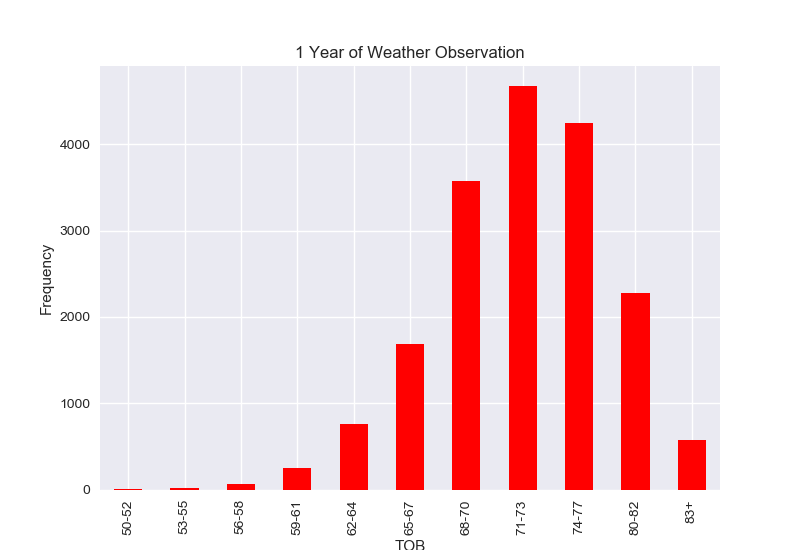

In [24]:
Tchart = tob_chart.plot(kind="bar", facecolor="red")
 # Set textual properties
plt.title("1 Year of Weather Observation")
plt.ylabel("Frequency")
plt.xlabel("TOB")
plt.savefig("images/1_yr_weather.png")
plt.show()

In [25]:
#Data for trip dates between 05-20-2017 to 05-23-2017
sel = [Measurement.date,  
       func.avg(Measurement.tobs),
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),] 
tob_ave = session.query(*sel).\
filter(func.strftime("%Y-%m-%d", Measurement.date) <= "2017-05-23").\
filter(func.strftime("%Y-%m-%d", Measurement.date) >= "2017-05-20").\
group_by(Measurement.date).\
order_by(Measurement.tobs).all()
tob_ave

[('2017-05-22', 74.4, 71, 77),
 ('2017-05-20', 76.25, 72, 79),
 ('2017-05-21', 74.2, 69, 80),
 ('2017-05-23', 75.66666666666667, 69, 87)]

In [26]:
tobs_ave_df = pd.DataFrame(tob_ave, columns=['date','Average', 'Min', 'Max'])
tobs_ave_df

,date,Average,Min,Max
0,2017-05-22,74.400000,71,77
1,2017-05-20,76.250000,72,79
2,2017-05-21,74.200000,69,80
3,2017-05-23,75.666667,69,87


In [27]:
tobs_ave_df.dtypes

date        object
Average    float64
Min          int64
Max          int64
dtype: object

<IPython.core.display.Javascript object>


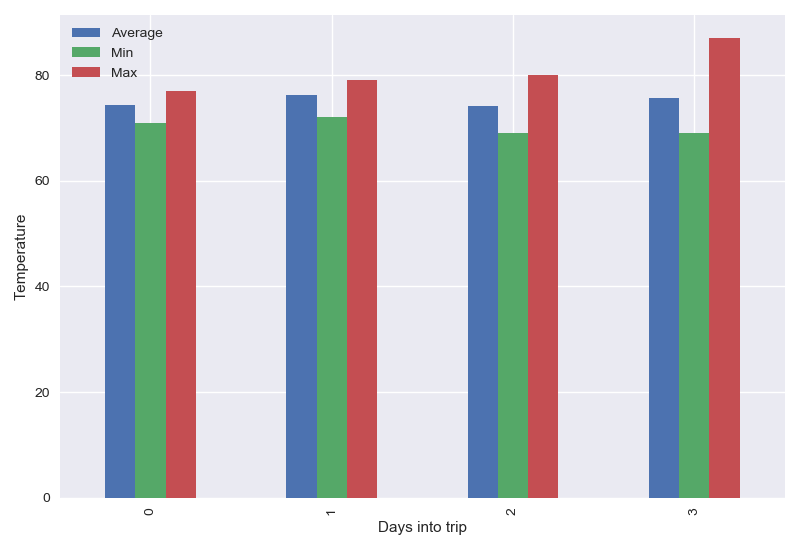

In [29]:
tobs_ave_df = pd.DataFrame(tob_ave, columns=['date','Average', 'Min', 'Max'])
tobs_ave_df.plot.bar()
plt.xlabel("Days into trip")
plt.ylabel("Temperature")
plt.tight_layout()
plt.savefig("images/Trip_Temp.png")
plt.show()

In [30]:
maxt = tobs_ave_df['Max'].max()
mint = tobs_ave_df['Min'].min()
avetrip = tobs_ave_df['Average'].mean()

In [31]:
yerr_data = maxt - mint

<IPython.core.display.Javascript object>


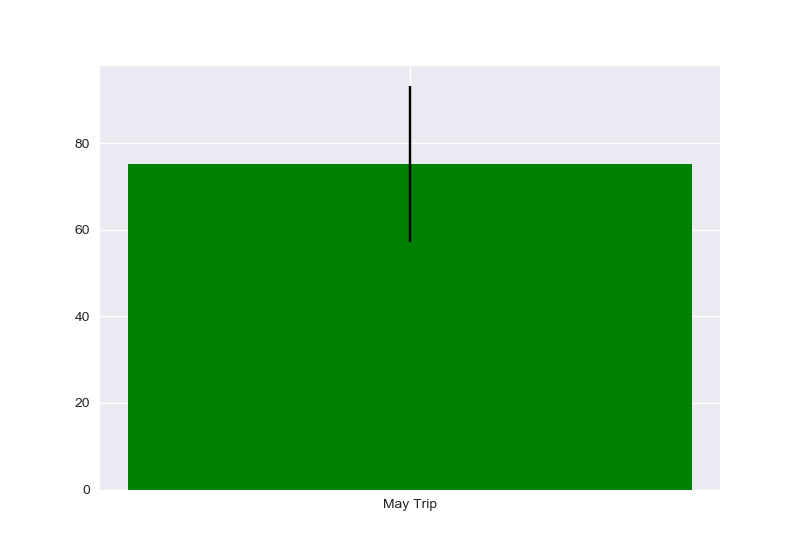

In [32]:
width = 0.10
fig, ax = plt.subplots()
ax.bar("May Trip",avetrip, width, color='G', yerr=yerr_data)
plt.savefig("images/Trip_YERR.png")
plt.show()